Train Shape: (1460, 81)
Test Shape: (1459, 80)

Columns in Train:
['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',

C:\Users\ISHA\AppData\Local\Temp\ipykernel_27172\1535356194.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing.values[:20], y=missing.index[:20], palette="magma")


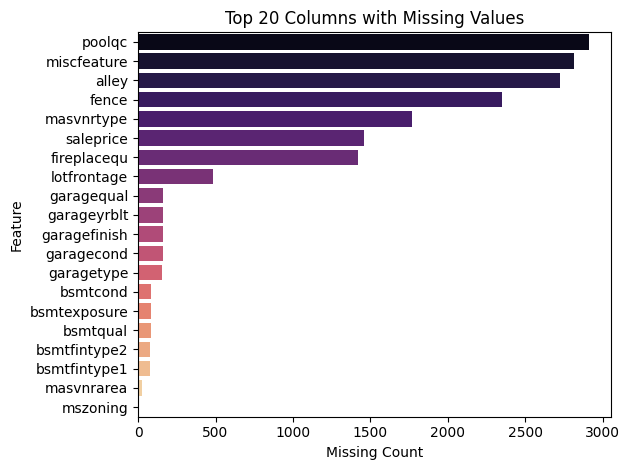


Missing values after imputation:
saleprice      1459
mszoning          4
saletype          1
mssubclass        0
lotfrontage       0
alley             0
lotshape          0
lotarea           0
street            0
lotconfig         0
dtype: int64

Found 43 categorical columns

 Final shape after encoding: (2919, 231)

 Engineered Features Added:
['total_sf', 'total_bathrooms', 'rooms_per_sf', 'house_age', 'since_remod', 'is_remodeled', 'total_porch_sf', 'overall_grade']

 Scaled dataset shape: (2919, 56)

 Final processed datasets saved:
- features/processed_train.csv
- features/processed_test.csv


In [1]:
# SECTION 1: Setup & Load Data

# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Paths
import os

BASE_DIR = "C:/Users/ISHA/OneDrive/Documents/GitHub/CelebalTechAssignmentWeek5"
DATA_DIR = os.path.join(BASE_DIR, "data")

TRAIN_PATH = os.path.join(DATA_DIR, "train.csv")
TEST_PATH  = os.path.join(DATA_DIR, "test.csv")

# Create folders if they don't exist
os.makedirs("visuals", exist_ok=True)
os.makedirs("features", exist_ok=True)

# Load datasets
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

# Keep a copy of original data (if needed later)
original_train = train_df.copy()
original_test = test_df.copy()

# Dataset Info
print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)

print("\nColumns in Train:")
print(train_df.columns.tolist())

print("\nSample Rows from Train:")
print(train_df.head())

# Check if 'SalePrice' is present in test
if "SalePrice" not in test_df.columns:
    test_df["SalePrice"] = np.nan  # for consistent processing

# SECTION 2: Initial Cleaning

# Drop ID column (not useful for modeling)
train_df.drop(columns=["Id"], inplace=True)
test_ids = test_df["Id"]  # Save IDs for future submission
test_df.drop(columns=["Id"], inplace=True)

# Combine datasets for uniform preprocessing
train_df["source"] = "train"
test_df["source"] = "test"

combined_df = pd.concat([train_df, test_df], ignore_index=True)

print(f"\nCombined dataset shape: {combined_df.shape}")
print("Source labels added: train/test distinction maintained")

# Standardize column names to lowercase
combined_df.columns = combined_df.columns.str.lower()

# SECTION 3: Missing Value Handling

# Missing Values Overview
missing = combined_df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

print("\nColumns with Missing Values:")
print(missing)

# Visualize Top 20 missing values
sns.barplot(x=missing.values[:20], y=missing.index[:20], palette="magma")
plt.title("Top 20 Columns with Missing Values")
plt.xlabel("Missing Count")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("visuals/missing_values_barplot.png", dpi=300)
plt.show()

# Smart Imputation (example for key columns)
# → Grouped into: categorical, numerical, zero-fill, or special

# Fill 'None' for features where NA means 'No'
none_features = [
    'alley', 'poolqc', 'fence', 'fireplacequ', 'miscfeature', 'garagecond',
    'garagetype', 'garagefinish', 'garagequal', 'bsmtqual', 'bsmtcond',
    'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'masvnrtype'
]
for col in none_features:
    combined_df[col] = combined_df[col].fillna("None")

# Fill 0 where missing means "No feature"
zero_features = ['masvnrarea', 'garageyrblt', 'bsmtfullbath', 'bsmthalfbath', 'garagecars', 'garagearea', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf']
for col in zero_features:
    combined_df[col] = combined_df[col].fillna(0)

# Mode imputation (most frequent category)
mode_features = ['electrical', 'kitchenqual', 'utilities', 'functional', 'exterior1st', 'exterior2nd', 'salecondition']
for col in mode_features:
    combined_df[col] = combined_df[col].fillna(combined_df[col].mode()[0])

# Neighborhood-based median imputation for LotFrontage
combined_df['lotfrontage'] = combined_df.groupby("neighborhood")["lotfrontage"].transform(
    lambda x: x.fillna(x.median())
)

# Double check
print("\nMissing values after imputation:")
print(combined_df.isnull().sum().sort_values(ascending=False).head(10))

# SECTION 4: Categorical Encoding

from sklearn.preprocessing import LabelEncoder

# Step 1: Identify Categorical Columns
cat_cols = combined_df.select_dtypes(include='object').columns.tolist()
cat_cols.remove('source')  # keep source for split later

print(f"\nFound {len(cat_cols)} categorical columns")

# Step 2: Manual Ordinal Mapping (these are not random categories)
ordinal_map = {
    "exterqual":     {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    "extercond":     {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    "bsmtqual":      {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    "bsmtcond":      {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    "heatingqc":     {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    "kitchenqual":   {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    "fireplacequ":   {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    "garagequal":    {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    "garagecond":    {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    "poolqc":        {'None':0, 'Fa':1, 'Gd':2, 'Ex':3}
}

# Apply ordinal encodings
for col, mapping in ordinal_map.items():
    if col in combined_df.columns:
        combined_df[col] = combined_df[col].map(mapping)

# Remove ordinal columns from list before one-hot encoding
for col in ordinal_map.keys():
    if col in cat_cols:
        cat_cols.remove(col)

# Step 3: One-Hot Encoding for Nominal Categorical Features
combined_df = pd.get_dummies(combined_df, columns=cat_cols, drop_first=True)

print(f"\n Final shape after encoding: {combined_df.shape}")

# SECTION 5: Feature Engineering

# Total square footage (1st + 2nd floor + basement)
combined_df['total_sf'] = combined_df['totalbsmtsf'] + combined_df['1stflrsf'] + combined_df['2ndflrsf']

# Total bathrooms (full = 1, half = 0.5)
combined_df['total_bathrooms'] = (
    combined_df['fullbath'] + 0.5 * combined_df['halfbath'] +
    combined_df['bsmtfullbath'] + 0.5 * combined_df['bsmthalfbath']
)

# Rooms per floor area (density)
combined_df['rooms_per_sf'] = combined_df['totrmsabvgrd'] / (combined_df['grlivarea'] + 1)

#  House age at sale
combined_df['house_age'] = combined_df['yrsold'] - combined_df['yearbuilt']

# Years since remodel
combined_df['since_remod'] = combined_df['yrsold'] - combined_df['yearremodadd']

# Was it remodeled?
combined_df['is_remodeled'] = (combined_df['yearremodadd'] != combined_df['yearbuilt']).astype(int)

# Total porch area
combined_df['total_porch_sf'] = (
    combined_df['openporchsf'] + combined_df['enclosedporch'] +
    combined_df['3ssnporch'] + combined_df['screenporch']
)

#  Interaction feature: overall grade
combined_df['overall_grade'] = combined_df['overallqual'] * combined_df['overallcond']

# Fix potential inf or NaN values after engineering
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
combined_df.fillna(0, inplace=True)

print("\n Engineered Features Added:")
print([
    'total_sf', 'total_bathrooms', 'rooms_per_sf', 'house_age', 'since_remod',
    'is_remodeled', 'total_porch_sf', 'overall_grade'
])

# SECTION 6: Feature Scaling

from sklearn.preprocessing import StandardScaler

# Drop non-numeric columns (like 'source') before scaling
scalable_df = combined_df.drop(columns=['source'])

#  Save the SalePrice separately (if present)
sale_price = None
if 'saleprice' in scalable_df.columns:
    sale_price = scalable_df['saleprice']
    scalable_df = scalable_df.drop(columns=['saleprice'])

# Identify numeric columns only
num_cols = scalable_df.select_dtypes(include=[np.number]).columns

#  Scale features using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(scalable_df[num_cols])

#  Create a DataFrame with scaled data
scaled_df = pd.DataFrame(scaled_data, columns=num_cols)

#  Re-attach SalePrice (unscaled) if it was separated
if sale_price is not None:
    scaled_df['saleprice'] = sale_price.values

#  Re-attach 'source' column for final split
scaled_df['source'] = combined_df['source'].values

print("\n Scaled dataset shape:", scaled_df.shape)

# SECTION 7: Save Final Features

# Split back into train/test
final_train = scaled_df[scaled_df['source'] == 'train'].drop(columns=['source'])
final_test = scaled_df[scaled_df['source'] == 'test'].drop(columns=['source', 'saleprice'])  # test has no saleprice

#  Reattach test IDs (from Section 2)
final_test['Id'] = test_ids.values

# Save to CSV
final_train.to_csv("features/processed_train.csv", index=False)
final_test.to_csv("features/processed_test.csv", index=False)

print("\n Final processed datasets saved:")
print("- features/processed_train.csv")
print("- features/processed_test.csv")
